In [1]:
text = []

with open('text8') as f:
    for line in f:
        text.append(line)
    text = ''.join(text)

vocab_size = len(set(text)) + 1
print(vocab_size)

28


In [2]:
EOS_id = 0

def char_to_id(char):
    if char == ' ':
        return 1
    else:
        return ord(char) - ord('a') + 2

def id_to_char(i):
    if i == 0:
        return ''
    elif i == 1:
        return ' '
    else:
        return chr(ord('a') + i - 2)
    
import numpy as np

text_ids = {'full': np.array(list(map(char_to_id, text)))}
print(text[:10])
print(text_ids['full'][:10])

 anarchism
[ 1  2 15  2 19  4  9 10 20 14]


In [3]:
text_length = len(text)
print(text_length)

text_ids['train'] = text_ids['full'][:int(text_length * 0.8)]
text_ids['eval'] = text_ids['full'][int(text_length * 0.8):int(text_length * 0.9)]
text_ids['decode'] = text_ids['full'][int(text_length * 0.9):]

100000000


In [4]:
def get_batch(text, chunk_length, batch_size):
    while True:
        chunk_starts = np.random.randint(len(text) - chunk_length, size=batch_size)
        yield np.array([text[chunk_start:chunk_start + chunk_length] for chunk_start in chunk_starts])

In [5]:
def revert_words(chunk_batch):
    rev_chunk_batch = []
    for chunk in chunk_batch:
        words = np.split(chunk, np.flatnonzero(chunk == char_to_id(' ')))
        rev_chunk = np.hstack([words[0][::-1]] + [np.roll(word[::-1], 1) for word in words[1:]])
        rev_chunk_batch.append(rev_chunk)
    return np.array(rev_chunk_batch)

chunk_batch = next(get_batch(text_ids['decode'], 10, 2))
print(chunk_batch)
print(revert_words(chunk_batch))

[[ 1  5  6  4 13 10 15  6  5  1]
 [ 2 19 12  6 21  1 24 10 21  9]]
[[ 1  5  6 15 10 13  4  6  5  1]
 [21  6 12 19  2  1  9 21 10 24]]


In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

In [40]:
train_losses_av_mean = {}
train_accs_av_mean = {}

eval_losses_av_mean = {}
eval_accs_av_mean = {}

train_losses_av_std = {}
train_accs_av_std = {}

eval_losses_av_std = {}
eval_accs_av_std = {}

In [88]:
class Seq2SeqModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_hidden, num_layers=1, dropout_rate=0.2):
        super(Seq2SeqModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.enc_rnn = nn.LSTM(embed_dim, num_hidden, num_layers,
                               batch_first=True, bidirectional=True)
        self.dec_cell = nn.LSTMCell(embed_dim, num_hidden * num_layers * 2)
        self.output_proj = nn.Linear(num_hidden * num_layers * 2, vocab_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, input_chunk, target_chunk=None, feed_mode='same', output_mode='argmax', baseline_mode=None):
        need_target_chunk = (feed_mode == 'teacher-forcing')
        if target_chunk is None and need_target_chunk:
            raise ValueError("You should provide target_chunk when using feed_mode '{}'".format(feed_mode))
        if feed_mode not in ['same', 'teacher-forcing', 'argmax', 'sampling']:
            raise ValueError("Invalid feed_mode: '{}'".format(feed_mode))
        if output_mode not in ['argmax', 'sampling']:
            raise ValueError("Invalid output_mode: '{}'".format(output_mode))
        if baseline_mode not in [None, 'argmax']:
            raise ValueError("Invalid baseline_mode: '{}'".format(baseline_mode))
            
        batch_size, chunk_length = input_chunk.size()
        
        # Encoder:
        input_chunk_emb = self.embedding(input_chunk)
        enc_h_first = autograd.Variable(
            torch.zeros(self.num_layers * 2, batch_size, self.num_hidden).cuda(),
            requires_grad=False
        )
        enc_c_first = autograd.Variable(
            torch.zeros(self.num_layers * 2, batch_size, self.num_hidden).cuda(),
            requires_grad=False
        )
        _, enc_hc_last = self.enc_rnn(input_chunk_emb, (enc_h_first, enc_c_first))
        
        # Decoder:
        dec_h = torch.transpose(enc_hc_last[0], 0, 1).contiguous().view(batch_size, -1)
        dec_c = torch.transpose(enc_hc_last[1], 0, 1).contiguous().view(batch_size, -1)
        
        dec_h_baseline = torch.transpose(enc_hc_last[0], 0, 1).contiguous().view(batch_size, -1)
        dec_c_baseline = torch.transpose(enc_hc_last[1], 0, 1).contiguous().view(batch_size, -1)
        
        dec_feed = None
        dec_feed_emb = autograd.Variable(
            torch.zeros(batch_size, self.embed_dim).cuda(),
            requires_grad=False
        )
        
        dec_feed_baseline = None
        dec_feed_baseline_emb = autograd.Variable(
            torch.zeros(batch_size, self.embed_dim).cuda(),
            requires_grad=False
        )
        
        dec_unscaled_logits = []
        dec_unscaled_logits_baseline = []
        dec_outputs = []
        self.dec_feeds = []
        
        target_chunk_emb = None
        if need_target_chunk:
            target_chunk_emb = self.embedding(target_chunk)
            
        for t in range(chunk_length):
            dec_h, dec_c = self.dec_cell(self.dropout(dec_feed_emb), (dec_h, dec_c))
            dec_unscaled_logits.append(self.output_proj(dec_h))
            
            if baseline_mode is not None:
                dec_h_baseline, dec_c_baseline = self.dec_cell(
                    dec_feed_baseline_emb, (dec_h_baseline, dec_c_baseline)
                )
                dec_unscaled_logits_baseline.append(self.output_proj(dec_h_baseline))
            
            if output_mode == 'argmax':
                dec_outputs.append(torch.max(dec_unscaled_logits[-1], dim=1)[1])
            elif output_mode == 'sampling':
                dec_outputs.append(torch.multinomial(torch.exp(dec_unscaled_logits[-1]), 1).view(batch_size))
            else:
                raise ValueError("Invalid output_mode: '{}'".format(output_mode))
                
            if feed_mode == 'same':
                dec_feed = dec_outputs[-1]
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            elif feed_mode == 'teacher-forcing':
                dec_feed = target_chunk[:, t]
                dec_feed_emb = target_chunk_emb[:, t]
            elif feed_mode == 'argmax':
                dec_feed = torch.max(dec_unscaled_logits[-1], dim=1)[1]
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            elif feed_mode == 'sampling':
                dec_feed = torch.multinomial(F.softmax(dec_unscaled_logits[-1]), 1)
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            else:
                raise ValueError("Invalid feed_mode: '{}'".format(feed_mode))
            self.dec_feeds.append(dec_feed)
        
            if baseline_mode == 'argmax':
                dec_feed_baseline = torch.max(dec_unscaled_logits_baseline[-1], dim=1)[1]
                dec_baseline_emb = self.embedding(dec_feed_baseline.view(batch_size, 1)).view(batch_size, self.embed_dim)
            elif baseline_mode is not None:
                raise ValueError("Invalid baseline_mode: '{}'".format(baseline_mode))
        
        if baseline_mode is not None:
            return (
                torch.stack(dec_unscaled_logits, dim=1), 
                torch.stack(dec_unscaled_logits_baseline, dim=1), 
                torch.stack(dec_outputs, dim=1)
            )
        else:
            return (
                torch.stack(dec_unscaled_logits, dim=1), 
                None,
                torch.stack(dec_outputs, dim=1)
            )

In [89]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
from time import time

train_batch_size = 64
eval_batch_size = 64
decode_batch_size = 8

chunk_length = 16

train_batch_gen = get_batch(text_ids['train'], batch_size=train_batch_size, chunk_length=chunk_length)
eval_batch_gen = get_batch(text_ids['eval'], batch_size=eval_batch_size, chunk_length=chunk_length)

num_runs = 3

num_steps = 50000
print_skip = 1000

train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

reinforce_strategy = 'argmax_advantage'

for run in range(num_runs):
    print('Run', run)
    print()
    
    train_losses.append([])
    train_accs.append([])
    eval_losses.append([])
    eval_accs.append([])

    cum_train_loss = 0
    cum_eval_loss = 0
    cum_train_acc = 0
    cum_eval_acc = 0
    
    train_av_loss = 0
    batch_av_train_av_loss = 0

    global_start_time = time()
    last_print_time = global_start_time

    model = Seq2SeqModel(vocab_size=vocab_size, embed_dim=8, num_hidden=48).cuda()
    
    init_lr = 0.01
    lr = init_lr
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for step in range(num_steps):        
        # Train:
        chunk_batch = next(train_batch_gen)
        rev_chunk_batch = revert_words(chunk_batch)
    
        chunk_batch_torch = autograd.Variable(torch.from_numpy(chunk_batch).cuda(), requires_grad=False)
        rev_chunk_batch_torch = autograd.Variable(torch.from_numpy(rev_chunk_batch).cuda(), requires_grad=False)
    
        if reinforce_strategy == 'argmax_advantage':
            unscaled_logits, unscaled_logits_baseline, outputs = model(
                chunk_batch_torch, rev_chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling', baseline_mode='argmax'
            )
        else:
            unscaled_logits, _, outputs = model(
                chunk_batch_torch, rev_chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling', baseline_mode=None
            )
        train_loss = loss_function(unscaled_logits.view(-1, vocab_size), rev_chunk_batch_torch.view(-1))
        train_acc = torch.mean(torch.eq(outputs, rev_chunk_batch_torch).float())
        
        if reinforce_strategy == 'element':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            batch_av_train_loss = torch.mean(elemwise_train_loss, dim=0)
            if step == 0:
                batch_av_train_av_loss = batch_av_train_loss
            else:
                batch_av_train_av_loss = 0.99 * batch_av_train_av_loss + 0.01 * batch_av_train_loss
            normed_batch_centered_train_loss = ((elemwise_train_loss - batch_av_train_av_loss) / 
                                                (train_batch_size * chunk_length))
            seqwise_train_loss = torch.sum(normed_batch_centered_train_loss, dim=1)
            seqwise_cum_train_loss = torch.cumsum(normed_batch_centered_train_loss, dim=1)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (-1) * (seqwise_train_loss - seqwise_cum_train_loss[:, t]).view(train_batch_size, 1)
                )
        elif reinforce_strategy == 'argmax_advantage':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            elemwise_train_loss_baseline = (-1) * F.log_softmax(
                unscaled_logits_baseline.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            normed_elemwise_advantage = ((elemwise_train_loss_baseline - elemwise_train_loss) /
                                         (train_batch_size * chunk_length))
            sum_normed_elemwise_advantage = torch.sum(normed_elemwise_advantage, dim=1)
            cumsum_normed_elemwise_advantage = torch.cumsum(normed_elemwise_advantage, dim=1)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (sum_normed_elemwise_advantage - cumsum_normed_elemwise_advantage[:, t]).view(train_batch_size, 1)
                )
        elif reinforce_strategy == 'sequence':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            if step == 0:
                train_av_loss = train_loss.data
            else:
                train_av_loss = 0.99 * train_av_loss + 0.01 * train_loss.data
            seq_av_train_loss = torch.mean(elemwise_train_loss, dim=1, keepdim=True)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (-1) * (seq_av_train_loss - train_av_loss) / (train_batch_size * chunk_length)
                )
        elif reinforce_strategy == 'none':
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(torch.zeros(train_batch_size, 1).cuda())
        else:
            raise ValueError("Invalid reinforce_strategy: '{}'".format(reinforce_strategy))
        optimizer.zero_grad()
        train_loss.backward()
        #nn.utils.clip_grad_norm(model.parameters(), max_norm=5)
        #lr = init_lr / (step + 1) ** 0.5
        #for group in optimizer.param_groups:
        #    group['lr'] = lr
        optimizer.step()
    
        # Eval:
        chunk_batch = next(eval_batch_gen)
        rev_chunk_batch = revert_words(chunk_batch)
    
        chunk_batch_torch = autograd.Variable(torch.from_numpy(chunk_batch).cuda(), requires_grad=False)
        rev_chunk_batch_torch = autograd.Variable(torch.from_numpy(rev_chunk_batch).cuda(), requires_grad=False)
    
        unscaled_logits, _, outputs = model(
            chunk_batch_torch,
            output_mode='argmax', feed_mode='sampling'
        )
        eval_loss = loss_function(unscaled_logits.view(-1, vocab_size), rev_chunk_batch_torch.view(-1))
        eval_acc = torch.mean(torch.eq(outputs, rev_chunk_batch_torch).float())

        train_losses[run].append(train_loss.data.cpu().numpy().mean())
        train_accs[run].append(train_acc.data.cpu().numpy().mean())
        eval_losses[run].append(eval_loss.data.cpu().numpy().mean())
        eval_accs[run].append(eval_acc.data.cpu().numpy().mean())
        
        cum_train_loss += train_losses[run][-1]
        cum_train_acc += train_accs[run][-1]
        cum_eval_loss += eval_losses[run][-1]
        cum_eval_acc += eval_accs[run][-1]
    
        if (step + 1) % print_skip == 0:
            print('Step', step + 1)
            print('Train loss: {:.2f}; train accuracy: {:.2f}'.format(
                cum_train_loss / print_skip, cum_train_acc / print_skip
            ))
            print('Eval loss: {:.2f}; eval accuracy: {:.2f}'.format(
                cum_eval_loss / print_skip, cum_eval_acc / print_skip
            ))
            cum_train_loss = 0
            cum_eval_loss = 0
            cum_train_acc = 0
            cum_eval_acc = 0
        
            outputs_np = outputs.data.cpu().numpy()
            for i in range(decode_batch_size):
                print('{}|  vs  |{}'.format(
                    ''.join(list(map(id_to_char, chunk_batch[i]))),
                    ''.join(list(map(id_to_char, outputs_np[i])))
                ))
            
            print('{:.2f}s from last print'.format(time() - last_print_time))
            last_print_time = time()
            print()
    
    print('{} steps took {:.2f}s\n'.format(num_steps, time() - global_start_time))

Run 0

Step 1000
Train loss: 1.88; train accuracy: 0.43
Eval loss: 1.88; eval accuracy: 0.43
esiccation of th|  vs  |noitacoroa ft tt
oys of summer sh|  vs  |sso fo secres tt
tom usually has |  vs  |mot dlluoos taa 
 eight krupp pro|  vs  | tamim rrrap oop
ted it is also a|  vs  |det ti daa das a
uch of a feel so|  vs  |hcu fo l oeeo oc
one eight six se|  vs  |eno teees ses ee
ic ideas in one |  vs  |ci sceed ni eno 
127.40s from last print



In [48]:
def running_average(a, alpha=0.99):
    av = a[:1]
    for el in a[1:]:
        av.append((1 - alpha) * el + alpha * av[-1])
    return av

In [92]:
train_losses_av = []
train_accs_av = []

eval_losses_av = []
eval_accs_av = []

for run in range(len(train_losses)):
    train_losses_av.append(running_average(train_losses[run]))
    train_accs_av.append(running_average(train_accs[run]))

    eval_losses_av.append(running_average(eval_losses[run]))
    eval_accs_av.append(running_average(eval_accs[run]))
            
train_losses_av_mean[reinforce_strategy] = np.mean(train_losses_av, axis=0)
train_accs_av_mean[reinforce_strategy] = np.mean(train_accs_av, axis=0)

eval_losses_av_mean[reinforce_strategy] = np.mean(eval_losses_av, axis=0)
eval_accs_av_mean[reinforce_strategy] = np.mean(eval_accs_av, axis=0)
    
train_losses_av_std[reinforce_strategy] = np.std(train_losses_av, axis=0)
train_accs_av_std[reinforce_strategy] = np.std(train_accs_av, axis=0)

eval_losses_av_std[reinforce_strategy] = np.std(eval_losses_av, axis=0)
eval_accs_av_std[reinforce_strategy] = np.std(eval_accs_av, axis=0)

In [93]:
print('Train loss; mean: {:.2f}, std: {:.2f}'.format(
    train_losses_av_mean[reinforce_strategy][-1], 
    train_losses_av_std[reinforce_strategy][-1]
))
print('Train accuracy; mean: {:.2f}, std: {:.2f}'.format(
    train_accs_av_mean[reinforce_strategy][-1], 
    train_accs_av_std[reinforce_strategy][-1]
))
print('Eval loss; mean: {:.2f}, std: {:.2f}'.format(
    eval_losses_av_mean[reinforce_strategy][-1], 
    eval_losses_av_std[reinforce_strategy][-1]
))
print('Eval accuracy; mean: {:.2f}, std: {:.2f}'.format(
    eval_accs_av_mean[reinforce_strategy][-1], 
    eval_accs_av_std[reinforce_strategy][-1]
))


Train loss; mean: 0.75, std: 0.00
Train accuracy; mean: 0.76, std: 0.00
Eval loss; mean: 0.77, std: 0.00
Eval accuracy; mean: 0.75, std: 0.00


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

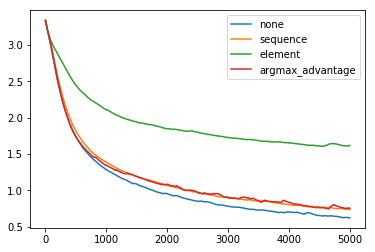

In [95]:
strategies = ['none', 'sequence', 'element', 'argmax_advantage']
#strategies = ['sequence', 'none']
for strategy in strategies:
    plt.plot(range(num_steps), train_losses_av_mean[strategy][:num_steps])
    #plt.fill_between(
    #    range(num_steps),
    #    train_losses_av_mean[strategy] - train_losses_av_std[strategy],
    #    train_losses_av_mean[strategy] + train_losses_av_std[strategy],
    #    alpha=0.5
    #)
plt.legend(strategies)

In [ ]:
# chunk_length = 8, num_steps = 10000:
# none: 0.03 +- 0.00
# sequence: 0.03 +- 0.00
# element: 0.12 +- 0.00

# chunk_length = 16, num_steps = 50000:
# none: 0.28 +- 0.01
# sequence: 0.39 +- 0.10
# element: 1.21 +- 0.07
